
<p><center style="color:#ff00ff; font-family:Arial; font-size:30px;">Thanks for visiting my notebook👀 
    </center></p>

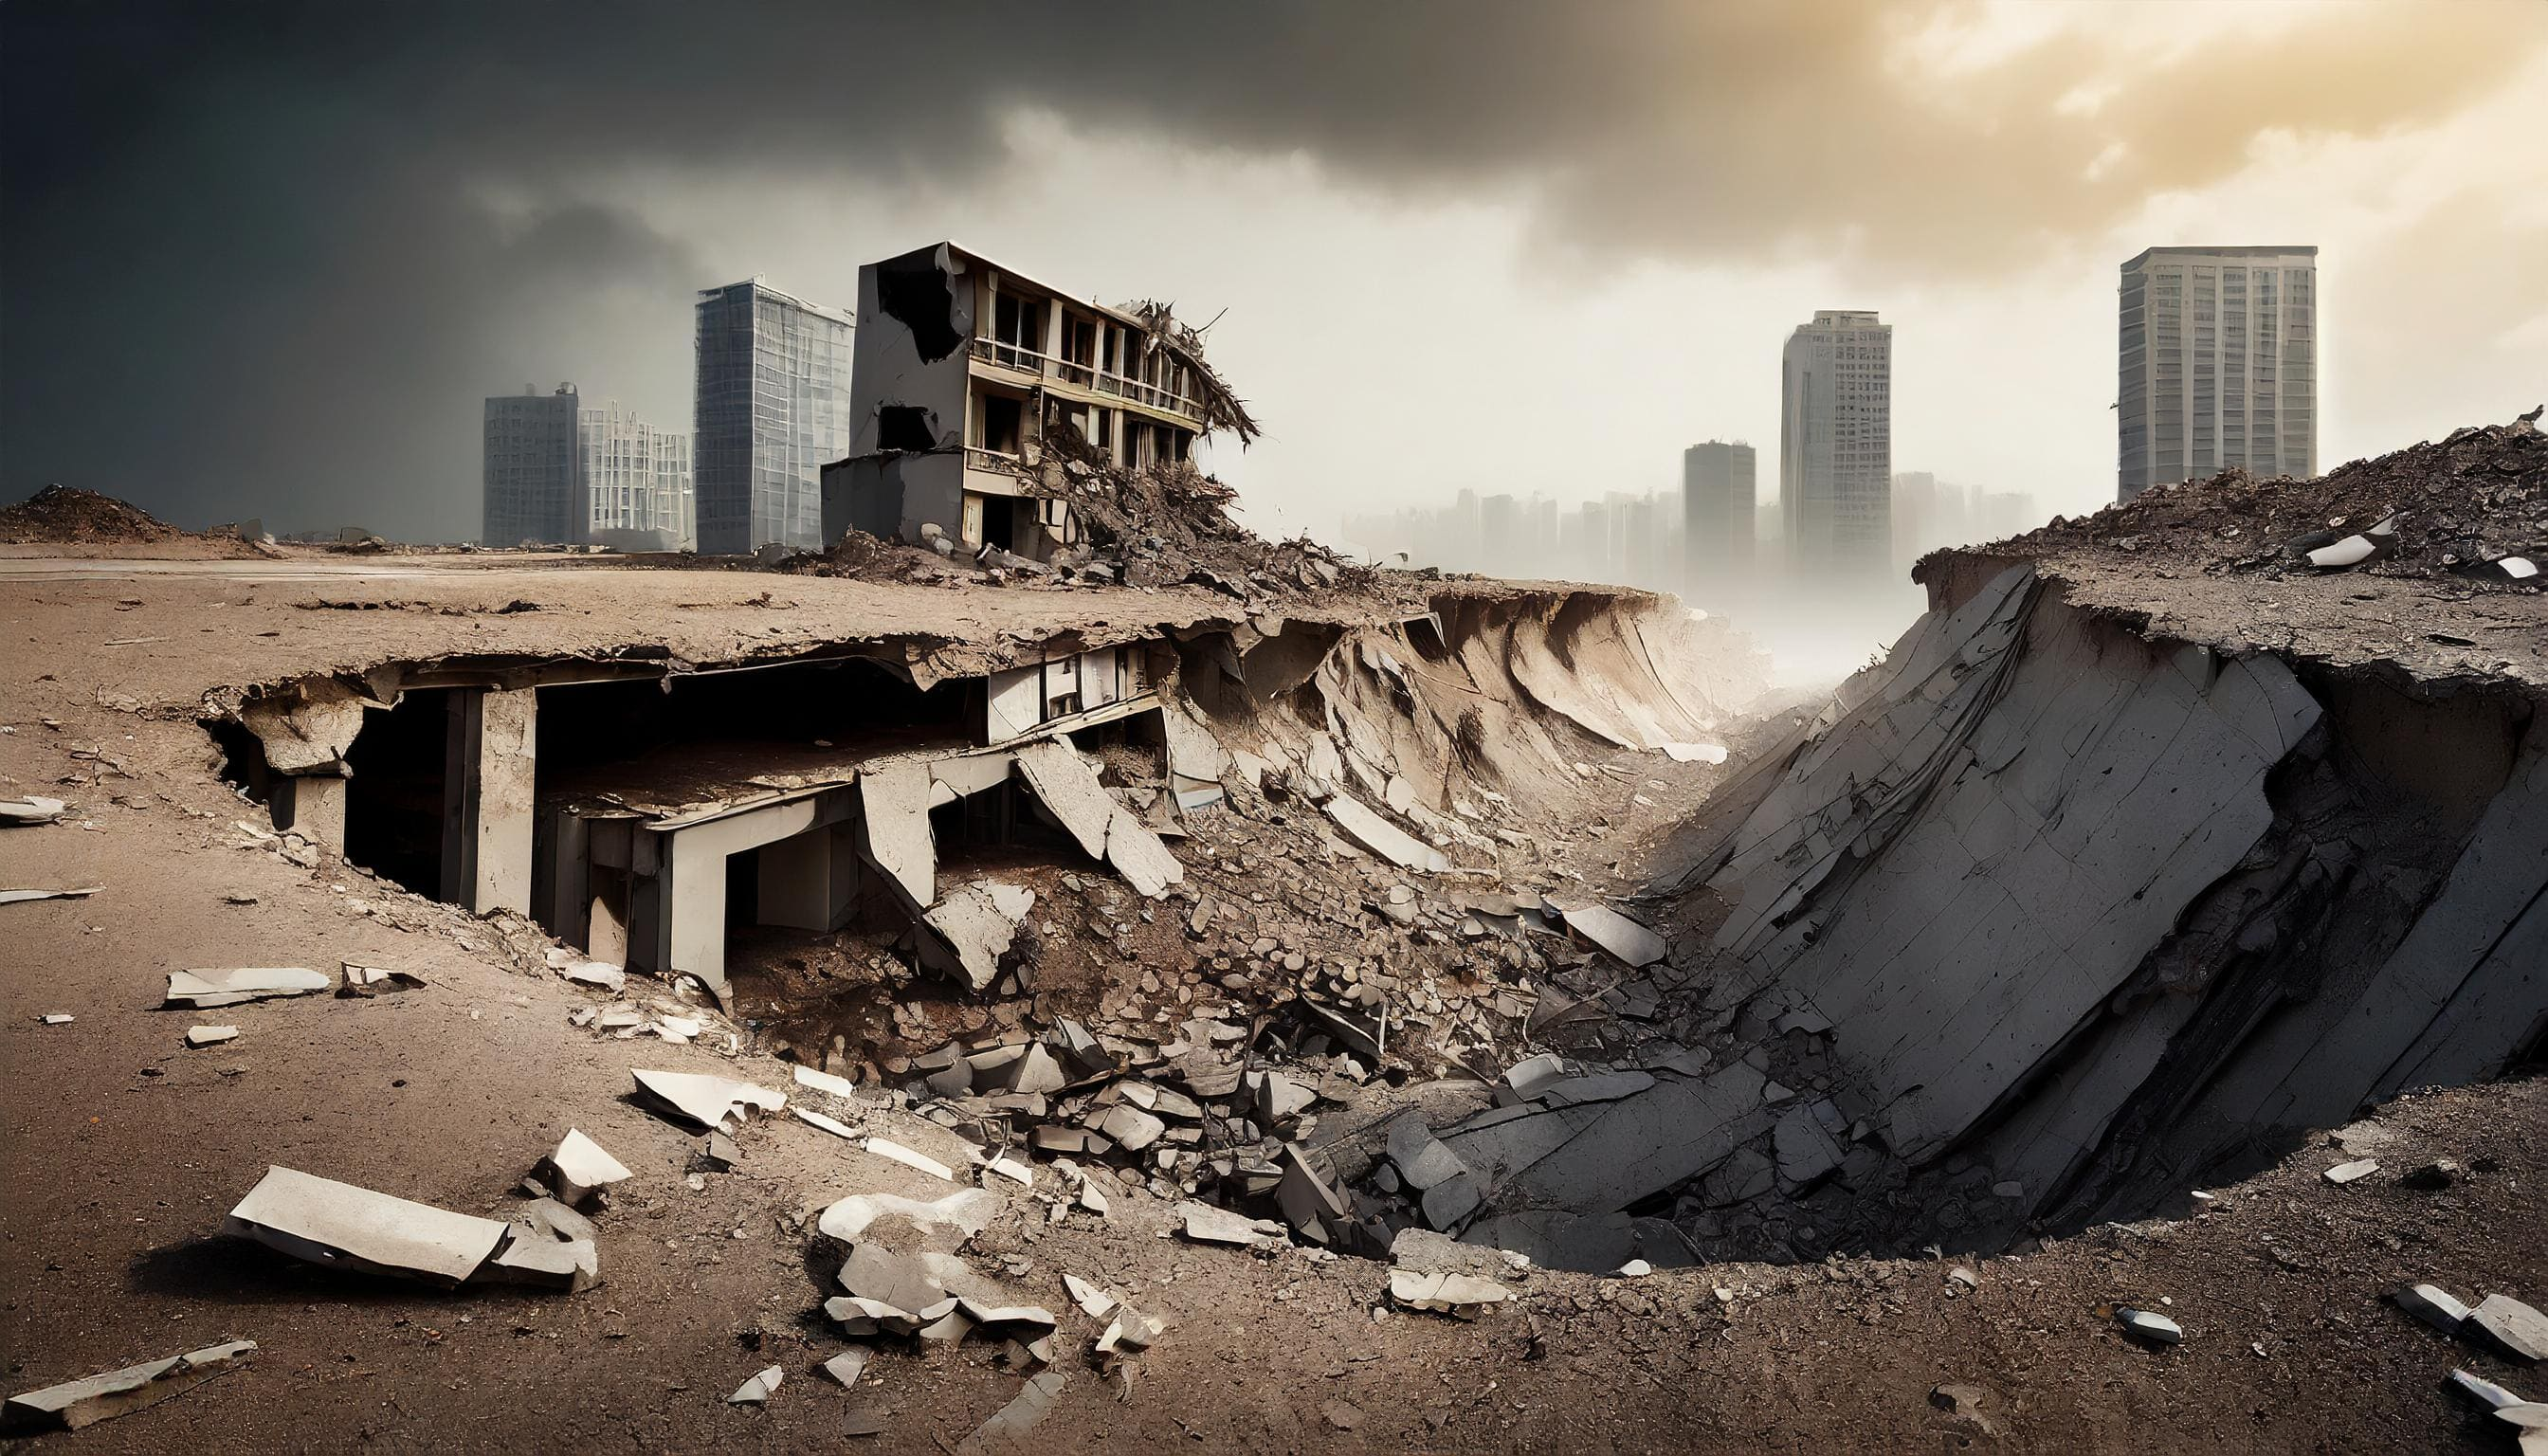

<p><center style="color:#ff0000; font-family:Arial; font-size:20px;">Taiwan is a region with frequent earthquakes, especially in the eastern areas. This is a data visualization of that occurrence, and through analyzing past events, let's identify preventive measures that can be implemented🧐
    </center></p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import seaborn as sns
import folium

<a id="3"></a>
# <p style="padding:20px;background-color:#fa8072 ;margin:0;color:#f2e9e4;font-family: 'Times New Roman';font-size:90%;text-align:center;border-radius: 15px 80px;overflow:hidden;font-weight:100 ; border: 2px solid #fefae0; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">Data </p>

In [2]:
df_disastrous = pd.read_csv('/kaggle/input/taiwan-earthquake-dataset/disastrous earthquake.csv')
df_disastrous.head(3)

,Date,Location,Latitude,Longitude,Depth (km),Magnitude,Casualties,Injured,Missing,Collapsed building
0,1720-10-31,Tainan,23.4,120.5,-,6.0,many deaths,NaN,NaN,NaN
1,1736-01-30,Tainan-Jiayi,23.1,120.3,-,7.0,372,NaN,NaN,689
2,1776-12-11,Jiayi,-,-,-,-,many deaths,NaN,NaN,NaN


In [3]:
df_detail = pd.read_csv('/kaggle/input/taiwan-earthquake-dataset/earthquake detail.csv')
df_detail.head(3)

,date,time,lat,lon,depth,ML,nstn,dmin,gap,trms,ERH,ERZ,fixed,nph,quality
0,1973-01-02,04:53:55.80,22.83,120.6700,15.0,2.88,6,41.0,153.0,0.19,1.3,6.2,N,6.0,C
1,1973-01-02,17:03:49.00,23.27,120.5817,1.0,2.99,4,34.0,149.0,0.05,0.0,0.0,N,4.0,C
2,1973-01-03,08:36:36.60,23.14,120.6150,10.0,4.10,5,49.0,138.0,0.24,3.3,4.1,N,5.0,D


<a id="3"></a>
# <p style="padding:20px;background-color:#fa8072 ;margin:0;color:#f2e9e4;font-family: 'Times New Roman';font-size:90%;text-align:center;border-radius: 15px 80px;overflow:hidden;font-weight:100 ; border: 2px solid #fefae0; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">Map : folium.Map() </p>

In [4]:
df = df_detail[df_detail['ML'] >5]
m = folium.Map(location=[23.5, 121], zoom_start=8)
for i, row in df.iterrows():
    if row['depth'] <= 5:
        color = 'red'
    elif 5 < row['depth'] <= 10:
        color = 'orange'
    else:
        color = 'blue'


    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"Date: {row['date']} Time: {row['time']}\nDepth: {row['depth']} km",
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)

display(m)

<a id="3"></a>
# <p style="padding:20px;background-color:#fa8072 ;margin:0;color:#f2e9e4;font-family: 'Times New Roman';font-size:90%;text-align:center;border-radius: 15px 80px;overflow:hidden;font-weight:100 ; border: 2px solid #fefae0; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">bargraph : plot(kind='bar') </p>

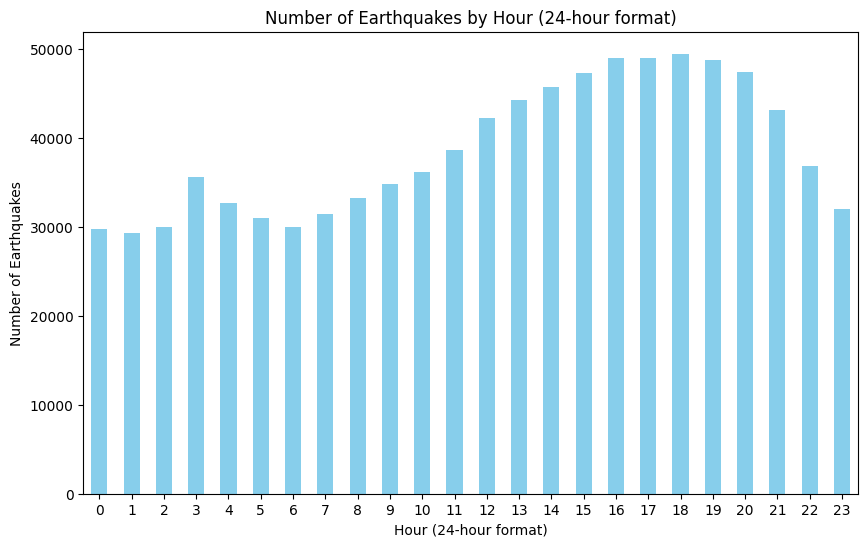

In [5]:
df_detail['hour'] = pd.to_datetime(df_detail['time'], format='%H:%M:%S.%f').dt.hour

earthquake_count_by_hour = df_detail['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
earthquake_count_by_hour.plot(kind='bar', color='skyblue')
plt.title('Number of Earthquakes by Hour (24-hour format)')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=0)
plt.show()

<a id="3"></a>
# <p style="padding:20px;background-color:#fa8072 ;margin:0;color:#f2e9e4;font-family: 'Times New Roman';font-size:90%;text-align:center;border-radius: 15px 80px;overflow:hidden;font-weight:100 ; border: 2px solid #fefae0; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">scattergraph : px.scatter() </p>

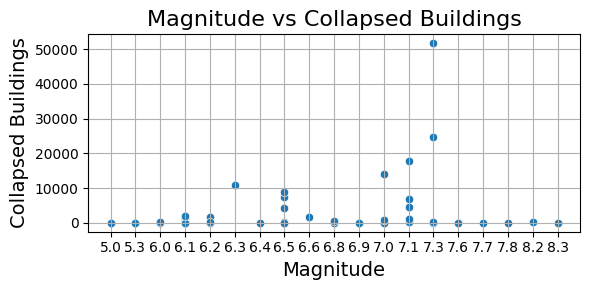

In [6]:
df_sorted = df_disastrous[['Casualties', 'Collapsed building', 'Magnitude']].dropna().sort_values(by=['Magnitude', 'Casualties', 'Collapsed building'])

df_sorted['Collapsed building'] = df_sorted['Collapsed building'].astype(int)

plt.figure(figsize=(6, 3))
sns.scatterplot(data=df_sorted, x='Magnitude', y='Collapsed building')

plt.title('Magnitude vs Collapsed Buildings', fontsize=16)
plt.xlabel('Magnitude', fontsize=14)
plt.ylabel('Collapsed Buildings', fontsize=14)

plt.grid(True)

plt.tight_layout()
plt.show()

<a id="3"></a>
# <p style="padding:20px;background-color:#fa8072 ;margin:0;color:#f2e9e4;font-family: 'Times New Roman';font-size:90%;text-align:center;border-radius: 15px 80px;overflow:hidden;font-weight:100 ; border: 2px solid #fefae0; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">bergraph : plot(kind='bar') </p>

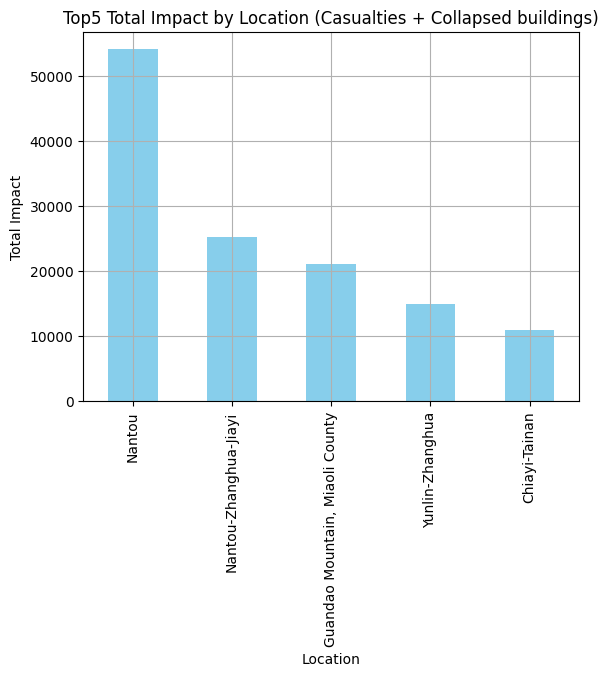

In [7]:
df_disastrous['Casualties'] = pd.to_numeric(df_disastrous['Casualties'], errors='coerce')
df_disastrous['Collapsed building'] = pd.to_numeric(df_disastrous['Collapsed building'], errors='coerce')

df_disastrous.fillna(0, inplace=True)
df_disastrous['Total Impact'] = df_disastrous['Casualties'] + df_disastrous['Collapsed building']

impact_by_location = df_disastrous.groupby('Location')['Total Impact'].sum().sort_values(ascending=False)
impact_five = impact_by_location[:5]


impact_five.plot(kind='bar', color='skyblue')

plt.title('Top5 Total Impact by Location (Casualties + Collapsed buildings)')
plt.xlabel('Location')
plt.ylabel('Total Impact')
plt.grid(True)
plt.show()

<a id="3"></a>
# <p style="padding:20px;background-color:#fa8072 ;margin:0;color:#f2e9e4;font-family: 'Times New Roman';font-size:90%;text-align:center;border-radius: 15px 80px;overflow:hidden;font-weight:100 ; border: 2px solid #fefae0; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">line graph : lineplot() </p>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


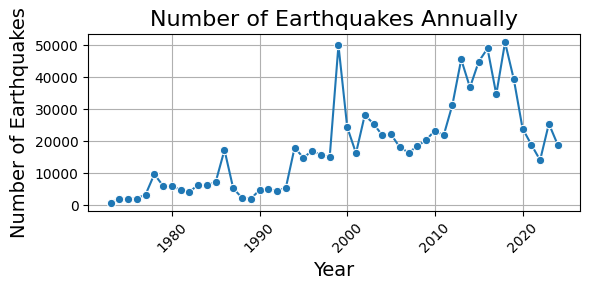

In [8]:
df_detail['date'] = pd.to_datetime(df_detail['date'], errors='coerce')

df_detail = df_detail.dropna(subset=['date'])

aa = df_detail['date'].dt.year.value_counts().sort_index().to_frame() 
aa.columns = ['Number of Earthquakes'] 

plt.figure(figsize=(6, 3))
sns.lineplot(data=aa, x=aa.index, y='Number of Earthquakes', marker='o')

plt.title('Number of Earthquakes Annually', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Earthquakes', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()